
# Connect Intensive - Machine Learning Nanodegree
# Lesson 03: Building and evaluating models with `sklearn`
# Part 02: Predictions, accuracy, and validation

## Objectives
  - Use the `sklearn` library to build a predictive `DecisionTreeClassifier` model for the Titanic Survival Dataset.
  - Compute the accuracy of a model on both the training and validation (testing) data.
  - Adjust hyperparameters (e.g. `max_depth`) to see the effects on model accuracy.
  - Visualize the model to understand how it makes decisions, and introduce the Gini impurity.
  
## Prerequisites
  - You should have the following python packages installed:
    - [matplotlib](http://matplotlib.org/index.html)
    - [numpy](http://www.scipy.org/scipylib/download.html)
    - [pandas](http://pandas.pydata.org/getpandas.html)
    - [sklearn](http://scikit-learn.org/stable/install.html)
  - You should have completed part 01 of this lesson to create the cleaned data sets. You can find all lessons in the [ConnectIntensive repo](https://github.com/nickypie/ConnectIntensive).
  - Optional prerequisites for visualizing the decision trees.
    - Install [graphviz](http://graphviz.org/), graph visualization software.
      - If you use [homebrew](http://brew.sh/), there's [a brew formula available for graphviz](http://brewformulas.org/Graphviz)
    - Install [pydotplus](https://pypi.python.org/pypi/pydotplus), a Python interface to Graphviz's Dot language


## Acknowledgements
  - This lesson is adapted from part 2 of Thomas Corcoran's excellent [`sklearn` tutorial](https://github.com/tccorcoran/Connect/tree/master/sklearn-tutorial). Thank you Thomas!

## Getting Started
As usual, we start by importing some useful libraries and modules. Don't worry if you get a warning message when importing `matplotlib` -- it just needs to build the font cache, and the warning is just to alert you that this may take a while the first time the cell is run.

**Run** the cell below (**click** the cell to highlight it, then press **shift + enter** or **shift + return**) to import useful libraries for this notebook.

In [1]:
%matplotlib inline
try:
    import matplotlib
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    print("Successfully imported matplotlib.pyplot! (Version {})".format(matplotlib.__version__))
except ImportError:
    print("Could not import matplotlib.pyplot!")
    
try:
    import numpy as np
    print("Successfully imported numpy! (Version {})".format(np.version.version))
except ImportError:
    print("Could not import numpy!")
    
try:
    import pandas as pd
    print("Successfully imported pandas! (Version {})".format(pd.__version__))
    pd.options.display.max_rows = 10
except ImportError:
    print("Could not import pandas!")

try:
    from IPython.display import display
    print("Successfully imported display from IPython.display!")
except ImportError:
    print("Could not import display from IPython.display")
    
try:
    import sklearn
    print("Successfully imported sklearn! (Version {})".format(sklearn.__version__))
    skversion = int(sklearn.__version__[2:4])
except ImportError:
    print("Could not import sklearn!")

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Successfully imported matplotlib.pyplot! (Version 1.5.3)
Successfully imported numpy! (Version 1.11.2)
Successfully imported pandas! (Version 0.19.0)
Successfully imported display from IPython.display!
Successfully imported sklearn! (Version 0.18)


## Loading the preprocessed data
In lesson-03-part-01.ipynb, we prepared the Titanic data for model building:
  - We explored the training data set to determine the predictive features to use in our models.
    - Features like `'Embarked'` and `'Pclass'` appeared to have useful predictive power.
    - Features like `'PassengerId'` and `'Ticket'` seemed less helpful.
  - We preprocessed the data to make it compatible with `sklearn`.
    - Missing values in the `'Age'` feature were imputed.
    - The categorical variables `'Sex'` and `'Embarked'` were changed to numeric features.
Now we want to use the preprocessed data to build a predictive model.

**Run** the cell below (**click** on the cell to highlight it, then press **shift + enter** or **shift + return** to run it) to read the preprocessed training and testing data into `pandas` `DataFrame` objects.

In [2]:
train_df = pd.read_csv("lesson-03-data/titanic_train_cleaned.csv")
test_df  = pd.read_csv("lesson-03-data/titanic_test_cleaned.csv")
print("Titanic data sets loaded!")

Titanic data sets loaded!


## Further dividing the data
The testing Titanic Survival data set from Kaggle intentionally does not have the `'Survived'` feature. So if we want to train and validate our model, we will need to further split our training data. In practice, this is often called training, validation, and testing sets.
  - **Training set:** A set of examples used for machine learning, that is to fit the parameters (*i.e.*, weights) of the classifier.
  - **Validation set:** A set of examples used to tune the hyperparameters (*i.e.*, architecture, not weights) of a classifier, for example to choose the maximum depth of a decision tree, or the number of hidden layers in a neural network.
  - **Test set:** A set of examples used only *once*. This assesses the performance (generalization) of the fully-specified classifier (once all hyperparameters have been specified).

So you can think of the three groups of data this way: you build a collection of models from the same training data set. The models might all be slightly different (*e.g.* decision trees of maximum depths of 1, 2, 3, 4, ...). You then apply each of these models to the validation data set. Based on how well each of these models performs, you may select an optimal depth, which was the adjustable *hyperparameter* for the decision tree classifier. Finally, once the model and all of its adjustable parameters have been decided upon, this model can be applied to the testing data to see how well it generalizes to unknown data.

For more on testing vs. validation data sets, you can consult the [test set wikipedia article](https://en.wikipedia.org/wiki/Test_set) or [this Quora post on training and testing data](https://www.quora.com/What-is-a-training-data-set-test-data-set-in-machine-learning-What-are-the-rules-for-selecting-them).


## Using `train_test_split`
The latest version of the library `sklearn` has the module `model_selection`, which contains [the method `train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). We can use this method to split `train_df` further into a training and a validation set. The arguments that we need to pass to `train_test_split()` are:
  - `X` & `y`: Arrays. These can be `pandas` `DataFrame` or `Series` objects.
  - `test_size`: A float with the proportion of data to put into the test set. *e.g.* `test_size = 0.1` would put one in every ten instances into the test set.
  - `random_state`: The pseudo-random number generator state used for random sampling. For a given value of `random_state`, the method will partition the data set exactly the same way each time, which is useful for debugging.

**Run** the cell below to create the `DataFrame` object `X` and the `Series` object `y` from the desired features from `train_df`. Then use `train_test_split()` with a `random_state` to split the dataset.

In [3]:
# Starting with scikit-learn version 0.18, the model_selection module replaces the cross_validation module,
# so we should import train_test_split from the appropriate module depending on the version number.
if skversion >= 18:
    from sklearn.model_selection import train_test_split
else:
    from sklearn.cross_validation import train_test_split

# Make a list of the desired feature names for model building
desired_features = ['Pclass', 'Sex', 'Age','SibSp','Parch', 'Cherbourg','Queenstown','Southampton']

# X is our pandas DataFrame object with the features from which we will predict the 'Survived' feature.
X = pd.DataFrame(train_df[desired_features])

# y is our pandas Series object with the 'Survived' feature to be predicted.
y = pd.Series(train_df['Survived'])

# Split the data into training and validation (test) data sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Take a look at the first few rows of the training features and classes
display(X_train.head())
display(y_train.head())

# Verify that the data sets were split 80% training and 20% testing
print("The original data ({} instances) was split into training ({} instances) and testing ({} instances) data sets".\
     format(len(X),len(X_train),len(X_test)))

,Pclass,Sex,Age,SibSp,Parch,Cherbourg,Queenstown,Southampton
146,3,1,27.0,0,0,0,0,1
195,1,0,58.0,0,0,1,0,0
786,3,0,18.0,0,0,0,0,1
290,1,0,26.0,0,0,0,0,1
521,3,1,22.0,0,0,0,0,1


146    1
195    1
786    1
290    1
521    0
Name: Survived, dtype: int64

The original data (891 instances) was split into training (712 instances) and testing (179 instances) data sets


Check out the indices on `X_train.head()` and `y_train.head()` -- they match, as expected, but they're shuffled, which may be unexpected! Also, the print statement above shows us that `train_test_split()` is partitioning the data based on the given `test_size` argument. Great!

## Building a Decision Tree Classifier
For supervised learning problems, the model building `sklearn` workflow is pretty similar, regardless of the type of classifier you'd like to build:
  1. **Create** a classifier object.
  2. **Train** the classifier on the training data set.
  3. **Predict** with the classifier on the validation (test) data set.
  4. **Assess** the accuracy of the classifier, comparing the predictions to the actual labels.

Let's try it here! Let's build a [Decision Tree Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) of `max_depth` 1. We will need to import `DecisionTreeClassifier` and `accuracy_score` from the appropriate `sklearn` modules.

**Run** the cell below to **create** a Decision Tree Classifier, **train** it on the training data, **predict** class labels for the validation (test) data set, and **assess** the accuracy of the classifier.

In [4]:
# Import DecisionTreeClassifier and accuracy_score from the appropriate sklearn modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 1. CREATE the classifier object... in this example, we call it clf1
clf1 = DecisionTreeClassifier(random_state=0, max_depth=1)

# 2. TRAIN the classifier object using the method .fit()
clf1.fit(X_train, y_train)

# 3. PREDICT labels for the validation (test) set using the method .predict()
y_pred_train = clf1.predict(X_train)
y_pred_test  = clf1.predict(X_test)

# 4. ASSESS the accuracy of the classifier, comparing the predictions to the actual labels.
print("The model with max_depth of {} has an accuracy of {:.1f}% on the training data, and {:.1f}% on the testing data".\
      format(1,\
             100.0*accuracy_score(y_pred_train,y_train),\
             100.0*accuracy_score(y_pred_test, y_test)))

The model with max_depth of 1 has an accuracy of 78.7% on the training data, and 78.8% on the testing data


Pretty good, right? Our decision tree of `max_depth` 1 correctly classified nearly 80% of the testing data! Let's look under the hood to see what criteria the decision tree classifier used to create its predictions.

## Visualizing a Decision Tree (Optional)
Some advantages to a decision tree classifier are that the classification process is simple to understand and interpret, and the decision tree can be easily visualized. Looking into the `sklearn` [documentation on Decision Trees](http://scikit-learn.org/stable/modules/tree.html), we see that there is a method, `export_graphviz`, where we can visualize the decision tree in [Graphviz format](http://www.graphviz.org/). Getting this working on your machine may be a little tricky, because there's an additional application and Python module needed, but I think the payoff is worth it.
  1. You need to install the [Graphviz](http://www.graphviz.org/) application. Note that [`pip install graphviz`](https://pypi.python.org/pypi/graphviz) is **not** sufficient. It does not install the Graphviz application.
  2. You need to install [the module `pydotplus`](https://pypi.python.org/pypi/pydotplus)
  
Once you've completed the installation prerequisites above, **run** the cell below to visualize the Decision Tree Classifier you created above with `max_depth` 1

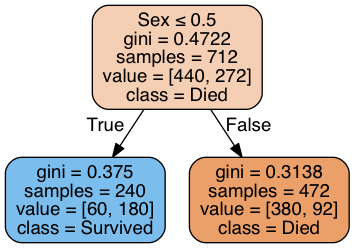

In [5]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = export_graphviz(clf1, out_file=None, 
                         feature_names=desired_features,  
                         class_names=['Died','Survived'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

So we see the decision tree drawn to the Jupyter Notebook! At the top is the **root node**, and we can see the question that the Decision Tree Classifier will use to make a decision. It will query the `'Sex'` feature, asking whether or not it is less than 0.5. If true, it moves along the left branch to the left leaf node, otherwise it moves to the right leaf node. Remember in the preprocessing step, we transformed the `'Sex'` feature into a numeric value of 0 for `'female'` passengers and 1 for `'male'` passengers. Let's describe some of the aspects of the graph:

  - **gini:** The [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity), or a measure of how often samples would be mislabeled at a given node. For a class with two possible labels...
    - The maximum possible value of `gini` is 0.5, when there is equal representation from both classes at the node.
    - The minimum possible value of `gini` is 0, when the node is purely a single class.
  - **samples:** the number of instances or inputs that reach that node of the tree. 
    - All 712 instances in the training set will pass through the root node, so `samples = 712` for the root node.
    - There are 240 females in the training set, so `samples = 240` for the females leaf node.
    - There are 472 males in the training set, so `samples = 472` for the males leaf node.
  - **value:** an array of length `n`, where `n` is the total number of distinct classes. Here, our classes were 0 and 1, indicating a passenger "Died" or "Survived".
    - Of the entire training set, 440 passengers Died and 272 passengers Survived, so `value = [440,272]` for the root node.
    - Of females in the training set, 60 passengers Died and 180 passengers Survived, so `value = [60,180]` for the females leaf node.
    - Of males in the training set, 380 passengers Died and 92 passengers Survived, so `value = [380,92]` for the males leaf node.
  - **class:** the best guess the Decision Tree Classifier can make at each node
    - At the root node, more passengers Died (440) than Survived (272), so the best guess it can make here is `class = Died`
    - At the females leaf node, fewer passengers Died (60) than Survived (180), so the best guess it can make here is `class = Survived`
    - At the males leaf node, more passengers Died (380) than Survived (92), so the best guess it can make here is `class = Died`

## Playing with hyperparameters
Hyperparameters of a model are explained pretty succinctly [in this Quora post](https://www.quora.com/What-are-hyperparameters-in-machine-learning). Basically, they are parameters that cannot be "learned" during the model training step. For example, you specify when you create the DecisionTreeClassifier object what the maximum allowed depth of the decision tree will be. That `max_depth` argument is a **hyperparameter**. During the model validation phase, a machine learnist often adjusts the hyperparamters and assesses how those adjustments improve the model on the training or testing set. Let's try it here!

**Run** the cell below to create a `DecisionTreeClassifier` object with a `max_depth` of 3. Does the model perform better or worse on the testing data than the original model with `max_depth` of 1? ...on the validation (test) data?

In [6]:
# 1. CREATE the classifier object... in this example, we call it clf3
clf3 = DecisionTreeClassifier(random_state=0, max_depth=3)

# 2. TRAIN the classifier object using the method .fit()
clf3.fit(X_train, y_train)

# 3. PREDICT labels for the validation (test) set using the method .predict()
y_pred_train = clf3.predict(X_train)
y_pred_test  = clf3.predict(X_test)

# 4. ASSESS the accuracy of the classifier, comparing the predictions to the actual labels.
print("The model with max_depth of {} has an accuracy of {:.1f}% on the training data, and {:.1f}% on the testing data".\
      format(3,\
             100.0*accuracy_score(y_pred_train,y_train),\
             100.0*accuracy_score(y_pred_test, y_test)))

The model with max_depth of 3 has an accuracy of 82.3% on the training data, and 80.4% on the testing data


**Run** the cell below to visualize the Decision Tree Classifier model with `max_depth` of 3.
  - Can you follow the decision tree?
  - At which leaf node(s) are the predictions the strongest (lowest gini impurity)?
  - At which leaf node(s) are the predictions the weakest (highest gini impurity)?

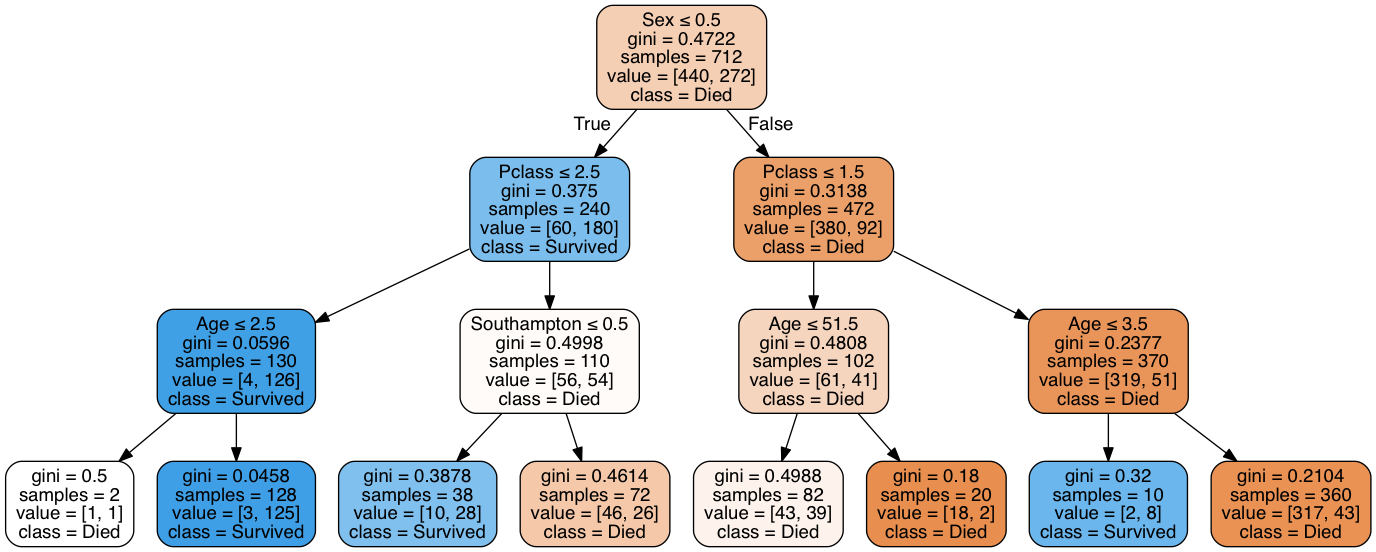

In [7]:
dot_data = export_graphviz(clf3, out_file=None, 
                         feature_names=desired_features,  
                         class_names=['Died','Survived'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

## Beware overfitting!
We could continue increasing `max_depth` and the accuracy on the training set should increase each time. However, the accuracy on the validation set will not necessarily improve with increasing tree depth. Why is this? As you increase the `max_depth` hyperparameter, your model becomes more strongly tuned to the training data set and you run the risk of **overfitting** your training data. This is a classic instnace of the bias vs. variance tradeoff, which is described wonderfully [in this blogpost](http://scott.fortmann-roe.com/docs/BiasVariance.html) by Scott Fortmann-Roe.

**Run** the cell below to see how well the Decision Tree Classifier works when we remove restrictions on the maximum depth -- the classifier will continue to split data until it runs out of possible features.

In [8]:
# 1. CREATE the classifier object... in this example, we call it clf
clf = DecisionTreeClassifier(random_state=0, max_depth = None)

# 2. TRAIN the classifier object using the method .fit()
clf.fit(X_train, y_train)

# 3. PREDICT labels for the validation (test) set using the method .predict()
y_pred_train = clf.predict(X_train)
y_pred_test  = clf.predict(X_test)

# 4. ASSESS the accuracy of the classifier, comparing the predictions to the actual labels.
print("The model with max_depth of {} has an accuracy of {:.1f}% on the training data, and {:.1f}% on the testing data".\
      format("None",\
             100.0*accuracy_score(y_pred_train,y_train),\
             100.0*accuracy_score(y_pred_test, y_test)))

The model with max_depth of None has an accuracy of 93.8% on the training data, and 78.2% on the testing data


We see that the accuracy on the training data is great, but our accuracy on the testing data didn't improve from the last model. In fact, it decreased! The model became too sensitive to trends in the training data that are not representative of the population as a whole.

## What could we do next?
Now that we've seen how to create, train, predict, and assess a classifier using `sklearn`, we are ready to try more advanced techniques:
  1. [More types of cross-validation, including k-fold cross validation.](http://scikit-learn.org/stable/modules/cross_validation.html)
  2. [Make validation curves and learning curves to see how well our models perform with different hyperparameters or training set sizes.](http://scikit-learn.org/stable/modules/learning_curve.html)
  3. [Perform an exhaustive grid search to tune and find the best possible hyperparameters](http://scikit-learn.org/stable/modules/grid_search.html)
  
I hope you're excited to try all these! If you'd like more practice right away, check out Thomas' [sklearn tutorial on GitHub](https://github.com/tccorcoran/Connect/tree/master/sklearn-tutorial).